In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering, AffinityPropagation, MiniBatchKMeans
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/all_recipe_data.json"

In [4]:
import json
raw_recipe_data = pd.read_json(datafile)

In [5]:
raw_recipe_data.isnull().values.any()

False

In [6]:
raw_recipe_data = raw_recipe_data.replace(np.nan, "", regex=True)
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [7]:
raw_recipe_data.isnull().sum()

Author          0
Instructions    0
dtype: int64

In [8]:
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [10]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])

raw_recipe_data.Author.value_counts()

exception                    118
LoveMexiFood                  13
TheBritishBaker               13
Johanna WISHES she were a     11
witchywoman                   11
bellepepper                   10
Peach822                      10
ellie                         10
Semigourmet                   10
Litegal1                      10
Chef John                     10
Name: Author, dtype: int64

In [14]:
#raw_recipe_data.drop(3, axis=0, inplace=True)
raw_recipe_data = raw_recipe_data[raw_recipe_data.Author != "exception"]


In [15]:
from string import punctuation

transtab = str.maketrans({key:None for key in punctuation if key != "."})

In [16]:
# remove punctuation
raw_recipe_data.Instructions = raw_recipe_data.Instructions.apply(lambda x: x.lower().translate(transtab).strip().split("."))
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,[mix grapefruit orange apples pineapple marasc...
1,witchywoman,"[fill a margarita glass with crushed ice, pou..."
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...
4,witchywoman,[mix the teriyaki sauce garlic ginger and red ...
5,witchywoman,[fill a pint glass with ice and pour in the vo...


In [17]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])
raw_recipe_data.head()

,Author,Instructions
0,w,[mix grapefruit orange apples pineapple marasc...
1,w,"[fill a margarita glass with crushed ice, pou..."
2,w,[preheat an oven to 350 degrees f 175 degrees ...
4,w,[mix the teriyaki sauce garlic ginger and red ...
5,w,[fill a pint glass with ice and pour in the vo...


In [18]:
raw_recipe_data.Instructions.iloc[0]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
 ' mash slightly with the back of a wooden spoon to release juices',
 ' add bananas coconut walnuts and sugar stir to coat',
 ' cover and refrigerate to blend flavors at least 1 hour',
 '']

In [70]:
raw_recipe_data.loc[:,"FullInstruction"] = raw_recipe_data.Instructions.apply(lambda x: "".join(x))


In [19]:
# Get Instructions: List of list of sentences; DONE
# Flatten list of list of sentences -> List of sentences; DONE
# Remove stopwords from each sentence; DONE
# Create Train/Test split of sentences; DONE
# Pass Training set into Gensim; DONE

In [71]:
# get instructions
sentences = [text for text in raw_recipe_data.FullInstruction]
sentences[:3]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl mash slightly with the back of a wooden spoon to release juices add bananas coconut walnuts and sugar stir to coat cover and refrigerate to blend flavors at least 1 hour',
 'fill a margarita glass with crushed ice pour tequila melon liqueur and triple sec into the glass top with sour mix grenadine lime juice and orange juice garnish with the cherry and a wedge of orange',
 'preheat an oven to 350 degrees f 175 degrees c grease 12 muffin cups or line with paper muffin liners stir the flour cinnamon nutmeg allspice cloves pumpkin pie spice cardamom ginger salt and baking soda together in a bowl beat the brown sugar and the eggs together with an electric mixer in a large bowl until smooth add 12 cup plus 2 tablespoons vegetable oil and pumpkin continue beating until integrated pour the flour mixture into the egg mixture and beat until just incorporated fill the prepared muffin cups about halffull with 

In [22]:
# flatten list of sentences
from itertools import chain

#sentences = list(chain.from_iterable(sentences))

In [72]:
len(sentences)

107

In [73]:
# remove empty strings
clean_sentences = list(filter(None, sentences))


In [74]:
len(clean_sentences)

107

In [75]:
# remove stop words
stoplist = set('a an and are as at be by for from has he in is it its of on or that the to was will with'.split(' '))
sentences_text = [[word for word in document.split() if word not in stoplist]
                  for document in clean_sentences]

In [76]:
# flatten list of words of sentences
combined_text = list(chain.from_iterable(sentences_text))


In [77]:
np.random.shuffle(sentences_text)
train, test = sentences_text[:562], sentences_text[562:]

In [78]:
len(sentences_text)

107

In [79]:
sentences_text[:3]

[['small',
  'saucepan',
  'over',
  'mediumlow',
  'heat',
  'whisk',
  'using',
  'metal',
  'whisk',
  'together',
  'vinegar',
  'cornstarch',
  'add',
  'oil',
  'pineapple',
  'juice',
  'ketchup',
  'brown',
  'sugar',
  'whisking',
  'constantly',
  'until',
  'mixture',
  'heated',
  'through'],
 ['preheat',
  'oven',
  '350',
  'degrees',
  'f',
  '175',
  'degrees',
  'c',
  'lightly',
  'grease',
  '2',
  'large',
  'baking',
  'sheets',
  'combine',
  'water',
  'mashed',
  'bananas',
  'honey',
  'vanilla',
  'egg',
  'large',
  'bowl',
  'stir',
  'wholewheat',
  'flour',
  'baking',
  'powder',
  'beat',
  'dough',
  'electric',
  'mixer',
  'medium',
  'speed',
  'until',
  'ingredients',
  'thoroughly',
  'combined',
  '1',
  '2',
  'minutes',
  'turn',
  'dough',
  'onto',
  'floured',
  'surface',
  'knead',
  'until',
  'no',
  'longer',
  'sticky',
  '5',
  '8',
  'minutes',
  'roll',
  'out',
  'dough',
  '14inch',
  'thickness',
  'cut',
  'into',
  'mini',
  's

In [80]:
train[:3]

[['small',
  'saucepan',
  'over',
  'mediumlow',
  'heat',
  'whisk',
  'using',
  'metal',
  'whisk',
  'together',
  'vinegar',
  'cornstarch',
  'add',
  'oil',
  'pineapple',
  'juice',
  'ketchup',
  'brown',
  'sugar',
  'whisking',
  'constantly',
  'until',
  'mixture',
  'heated',
  'through'],
 ['preheat',
  'oven',
  '350',
  'degrees',
  'f',
  '175',
  'degrees',
  'c',
  'lightly',
  'grease',
  '2',
  'large',
  'baking',
  'sheets',
  'combine',
  'water',
  'mashed',
  'bananas',
  'honey',
  'vanilla',
  'egg',
  'large',
  'bowl',
  'stir',
  'wholewheat',
  'flour',
  'baking',
  'powder',
  'beat',
  'dough',
  'electric',
  'mixer',
  'medium',
  'speed',
  'until',
  'ingredients',
  'thoroughly',
  'combined',
  '1',
  '2',
  'minutes',
  'turn',
  'dough',
  'onto',
  'floured',
  'surface',
  'knead',
  'until',
  'no',
  'longer',
  'sticky',
  '5',
  '8',
  'minutes',
  'roll',
  'out',
  'dough',
  '14inch',
  'thickness',
  'cut',
  'into',
  'mini',
  's

In [81]:
# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [82]:
model = gensim.models.Word2Vec(train, min_count=3, sg=1, window=5, sample=1e-3)

2018-04-30 13:35:10,918 : INFO : collecting all words and their counts
2018-04-30 13:35:10,920 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-30 13:35:10,924 : INFO : collected 1192 word types from a corpus of 6357 raw words and 107 sentences
2018-04-30 13:35:10,925 : INFO : Loading a fresh vocabulary
2018-04-30 13:35:10,929 : INFO : min_count=3 retains 486 unique words (40% of original 1192, drops 706)
2018-04-30 13:35:10,930 : INFO : min_count=3 leaves 5465 word corpus (85% of original 6357, drops 892)
2018-04-30 13:35:10,934 : INFO : deleting the raw counts dictionary of 1192 items
2018-04-30 13:35:10,936 : INFO : sample=0.001 downsamples 96 most-common words
2018-04-30 13:35:10,938 : INFO : downsampling leaves estimated 4091 word corpus (74.9% of prior 5465)
2018-04-30 13:35:10,942 : INFO : estimated required memory for 486 words and 100 dimensions: 631800 bytes
2018-04-30 13:35:10,943 : INFO : resetting layer weights
2018-04-30 13:35:10,959 : IN

In [83]:
X = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [114]:
len(model.wv.vocab)

486

In [84]:
model.wv.similarity('boil','bake')

0.9991647783665555

In [85]:
model.wv.similar_by_word('cake')

2018-04-30 13:35:11,201 : INFO : precomputing L2-norms of word weight vectors


[('lightly', 0.9995338916778564),
 ('4', 0.9995262026786804),
 ('have', 0.9995173215866089),
 ('when', 0.9995158314704895),
 ('hours', 0.9995149970054626),
 ('gently', 0.9995133280754089),
 ('each', 0.9995086193084717),
 ('you', 0.9995042085647583),
 ('top', 0.9994966983795166),
 ('using', 0.9994888305664062)]

# Dimentionality Reduction

In [86]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

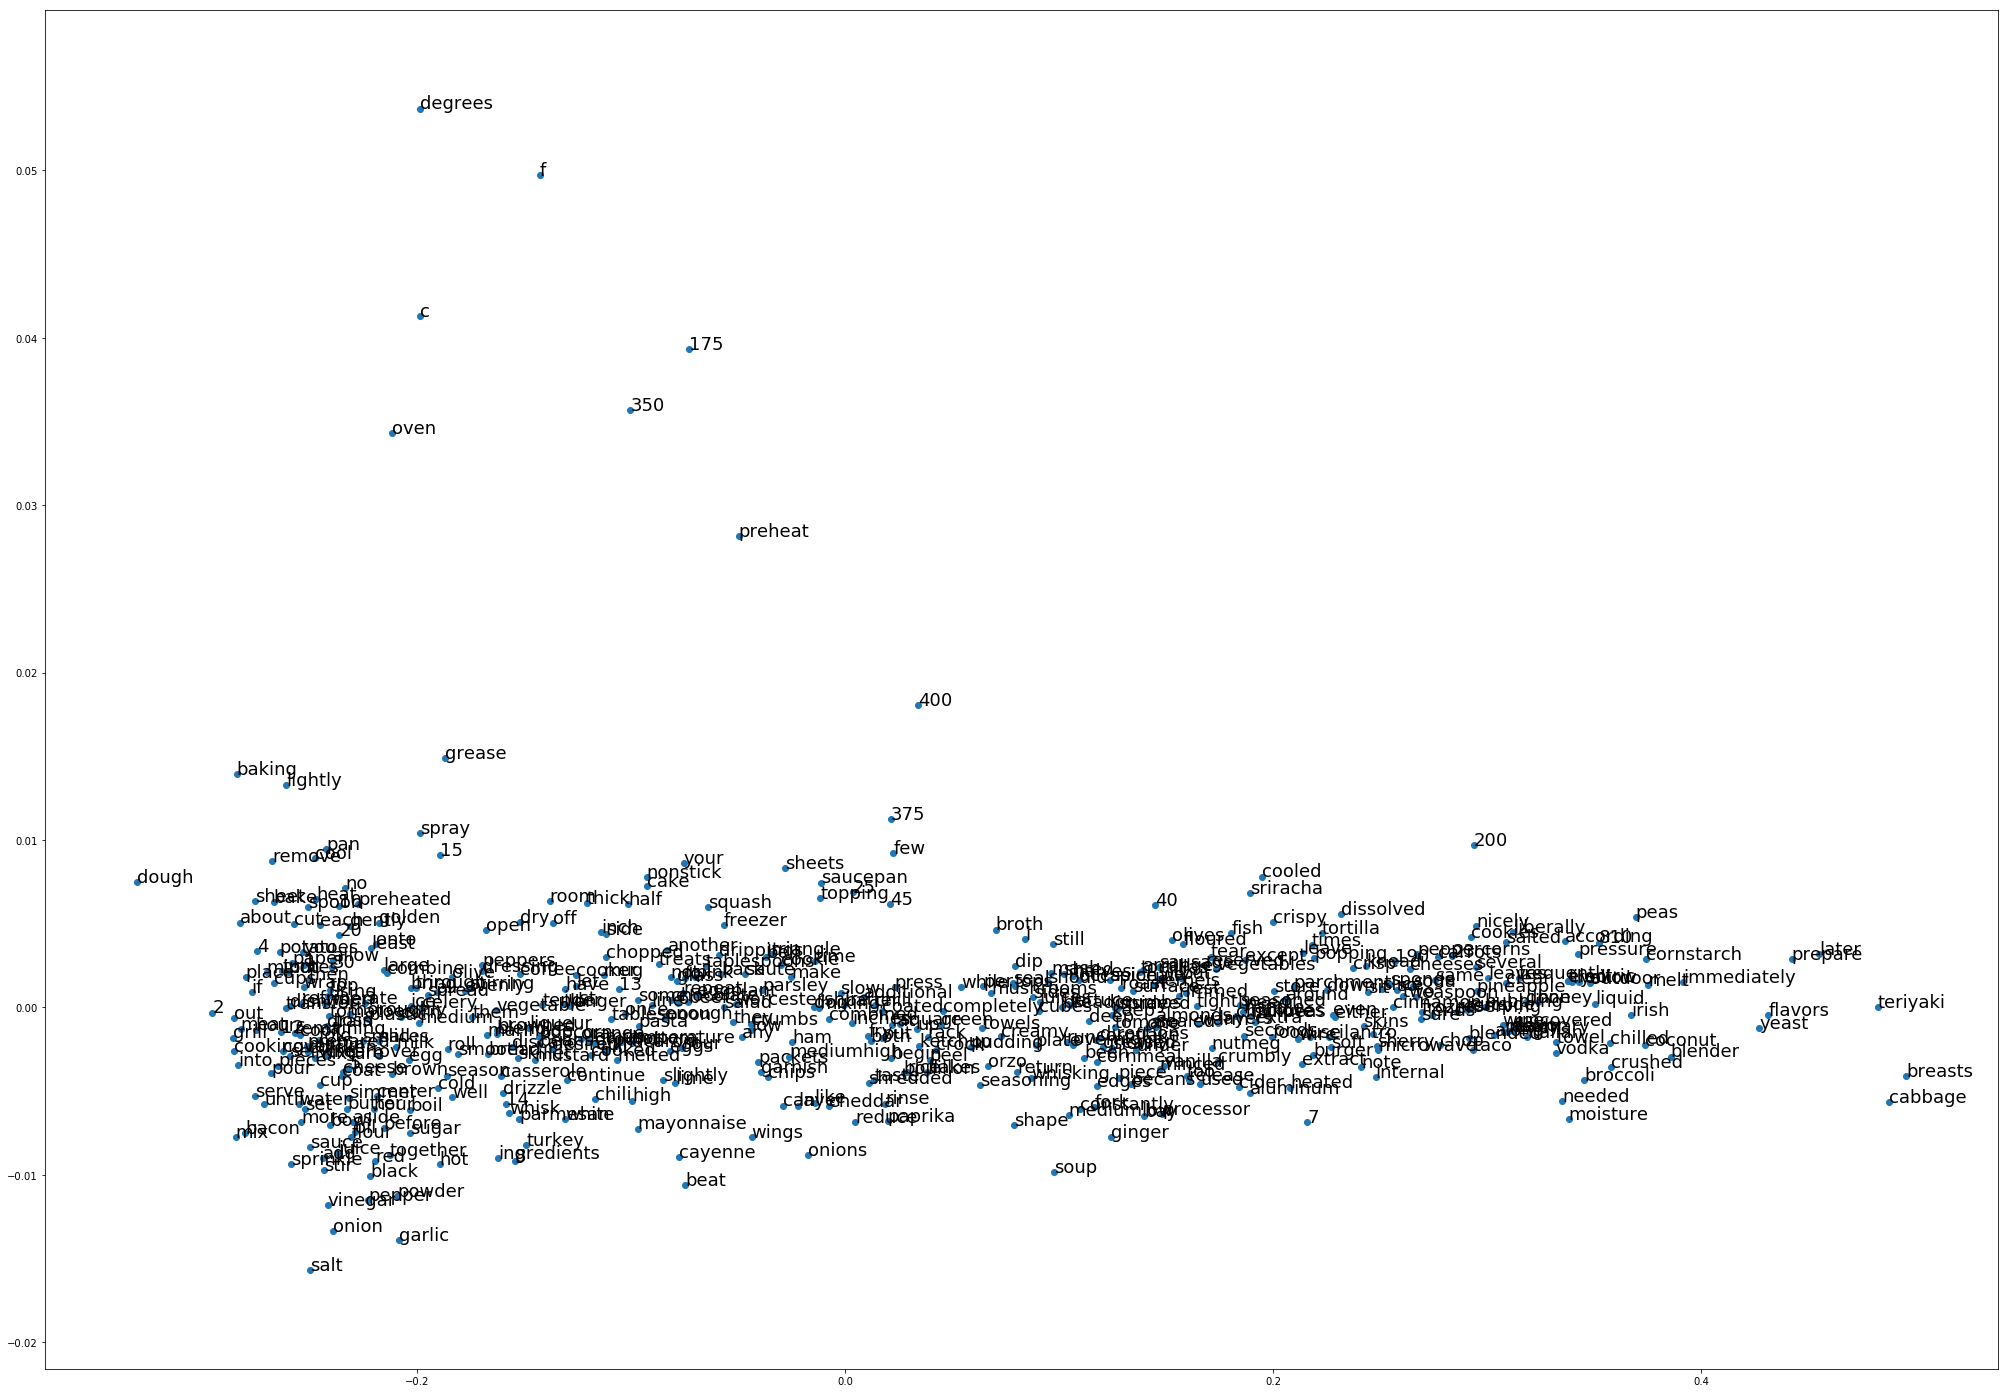

In [87]:
# PLOT PCA ONLY
plt.figure(figsize=((35,25)))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=18)


In [88]:
from sklearn import manifold

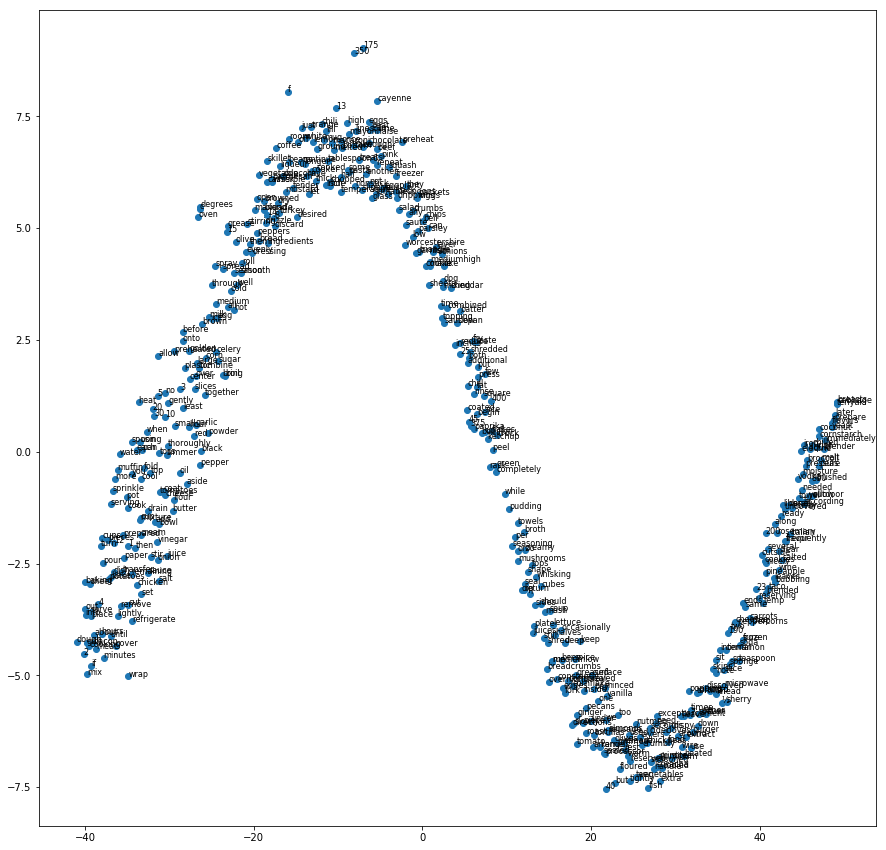

In [89]:
# PLOT TSNE ONLY
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=((15,15)))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=8)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


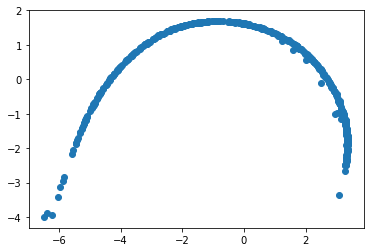

In [90]:
# PLOT MDS ONLY
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(X)
mds_data = mds.fit_transform(distances)
plt.scatter(mds_data[:, 0], mds_data[:, 1])

In [132]:
# PLOT TSVD ONLY
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=2)

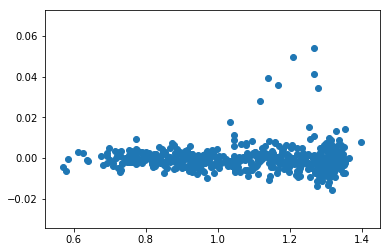

In [133]:
t_svd_data = t_svd.fit_transform(X)
plt.scatter(t_svd_data[:, 0], t_svd_data[:, 1])

# Clustering

In [93]:
# set up clustering estimators
from sklearn import cluster

dbscan = cluster.DBSCAN() 
meanshift = cluster.MeanShift()
spectral = cluster.SpectralClustering()
affinity = cluster.AffinityPropagation()

## DBSCAN on MDS data

In [107]:
# dbscan with MDS data
scanned_x = dbscan.fit(mds_data)

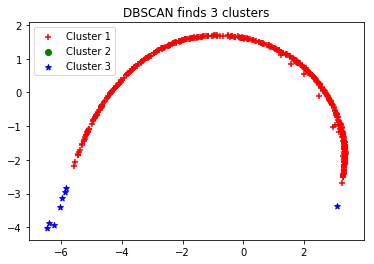

In [95]:
for i in range(0, mds_data.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.title('DBSCAN finds 3 clusters')
plt.show()

## DBSCAN on TSNE data

In [108]:
# lets see dbscan clusters for tsne
tsne_x = dbscan.fit(tsne_data)

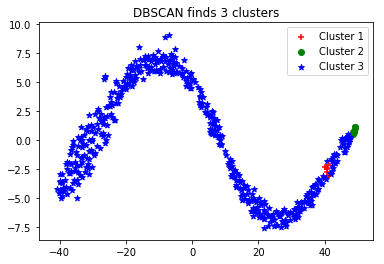

In [97]:
for i in range(0, tsne_data.shape[0]):
    if tsne_x.labels_[i] == 0:
        c1 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='r', marker='+')
    elif tsne_x.labels_[i] == 1:
        c2 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='g', marker='o')
    elif tsne_x.labels_[i] == -1:
        c3 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

## DBSCAN on PCA data

In [109]:
# dbscan with PCA data
pca_dbscan = dbscan.fit(pca_data)


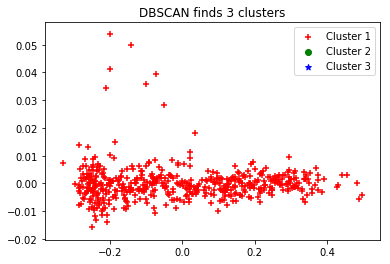

In [99]:
for i in range(0, pca_data.shape[0]):
    if pca_dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif pca_dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif pca_dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

## DBSCAN on TruncatedSVD

In [134]:
tsvd_dbscan = dbscan.fit(t_svd_data)

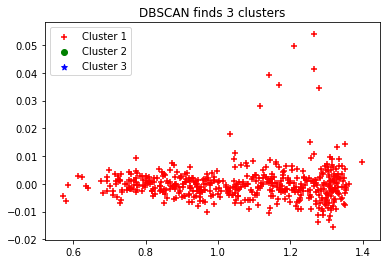

In [135]:
for i in range(0, t_svd_data.shape[0]):
    if tsvd_dbscan.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_dbscan.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_dbscan.labels_[i] == -1:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

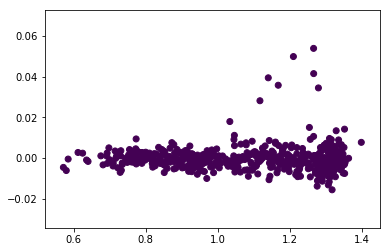

In [136]:
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_dbscan.labels_)


## MeanShift on PCA data

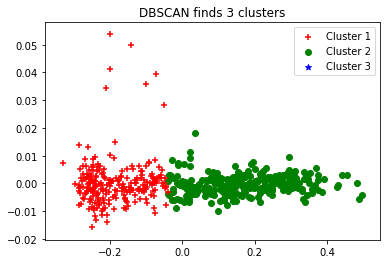

In [113]:
# Meanshift on PCA data
meanshift_pca = meanshift.fit(pca_data)
for i in range(0, pca_data.shape[0]):
    if meanshift_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif meanshift_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif meanshift_pca.labels_[i] == -1:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

## MeanShift on MDS data

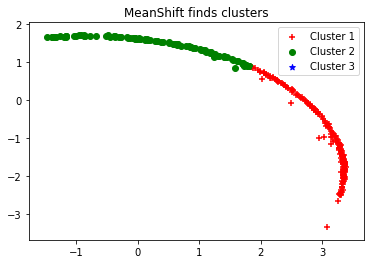

In [123]:
meanshift_mds = meanshift.fit(mds_data)
for i in range(0, mds_data.shape[0]):
    if meanshift_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif meanshift_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif meanshift_mds.labels_[i] == -1:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('MeanShift finds clusters')
plt.show()

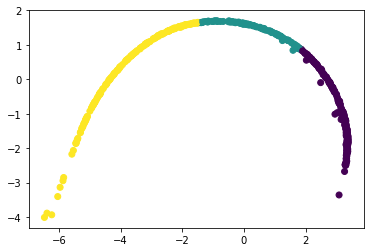

In [117]:
plt.scatter(mds_data[:, 0], mds_data[:,1], c = meanshift_mds.labels_)
# try another plot method

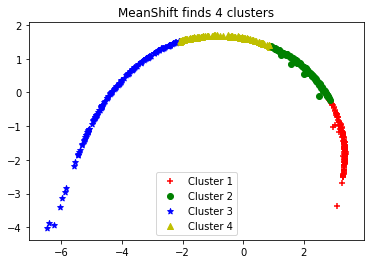

In [103]:
# meanshift mds
for i in range(0, mds_data.shape[0]):
    if meanshift_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif meanshift_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif meanshift_mds.labels_[i] == 2:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
    elif meanshift_mds.labels_[i] == 3:
        c4 = plt.scatter(mds_data[i,0], mds_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

## MeanShift on TSNE data

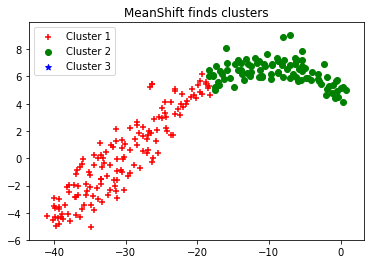

In [124]:
meanshift_tsne = meanshift.fit(tsne_data)
for i in range(0, pca_data.shape[0]):
    if meanshift_tsne.labels_[i] == 0:
        c1 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='r', marker='+')
    elif meanshift_tsne.labels_[i] == 1:
        c2 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='g', marker='o')
    elif meanshift_tsne.labels_[i] == -1:
        c3 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('MeanShift finds clusters')
plt.show()

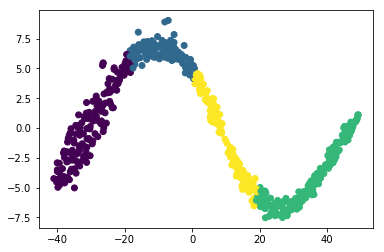

In [122]:
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = meanshift_tsne.labels_)
# compare two ways to plot

In [ ]:
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_x.labels_)


## MeanShift on PCA data

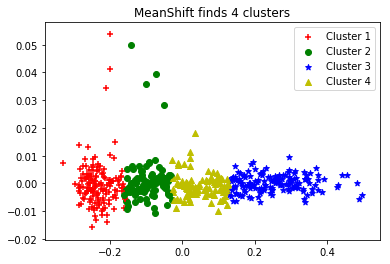

In [106]:
# meanshift pca
for i in range(0, pca_data.shape[0]):
    if meanshift_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif meanshift_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif meanshift_pca.labels_[i] == 2:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
    elif meanshift_pca.labels_[i] == 3:
        c4 = plt.scatter(pca_data[i,0], pca_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

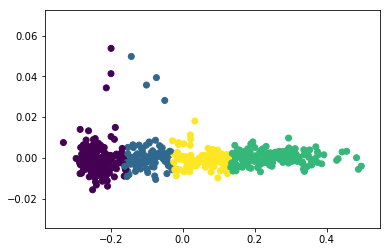

In [125]:
plt.scatter(pca_data[:, 0], pca_data[:,1], c = meanshift_pca.labels_)


## MeanShift on TSVD

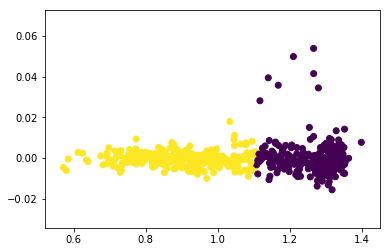

In [138]:
tsvd_meanshift = meanshift.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_meanshift.labels_)

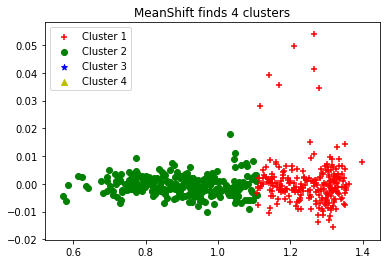

In [139]:
for i in range(0, t_svd_data.shape[0]):
    if tsvd_meanshift.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_meanshift.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_meanshift.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_meanshift.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

## Spectral Clustering 

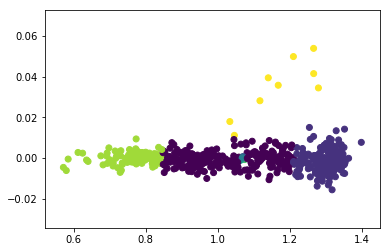

In [140]:
# truncated svd
tsvd_spectral = spectral.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral.labels_)

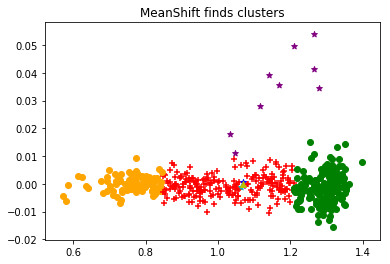

In [145]:
# truncated svd
for i in range(0, t_svd_data.shape[0]):
    if tsvd_spectral.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_spectral.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_spectral.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_spectral.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')
    elif tsvd_spectral.labels_[i] == 4:
        c5 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='c', marker='*')
    elif tsvd_spectral.labels_[i] == 5:
        c6 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='m', marker='+')
    elif tsvd_spectral.labels_[i] == 6:
        c7 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='orange', marker='o')
    elif tsvd_spectral.labels_[i] == 7:
        c8 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='purple', marker='*')

plt.title('MeanShift finds clusters')
plt.show()

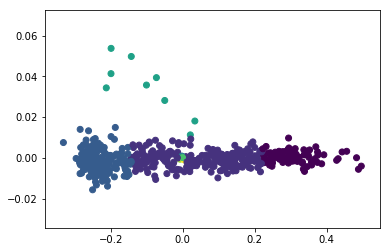

In [146]:
# PCA
spectral_pca = spectral.fit(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:,1], c = spectral_pca.labels_)

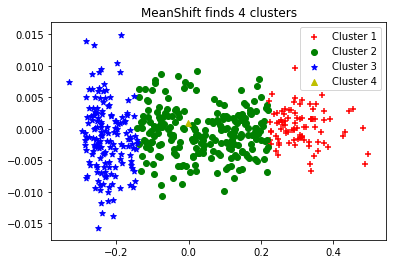

In [147]:
# PCA alt plot
# truncated svd
for i in range(0, pca_data.shape[0]):
    if spectral_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif spectral_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif spectral_pca.labels_[i] == 2:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
    elif spectral_pca.labels_[i] == 3:
        c4 = plt.scatter(pca_data[i,0], pca_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

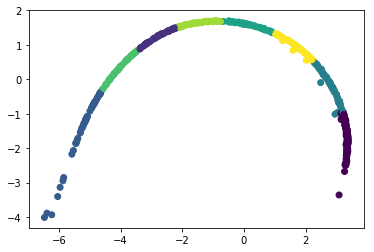

In [149]:
#MDS
spectral_mds = spectral.fit(mds_data)
plt.scatter(mds_data[:, 0], mds_data[:,1], c = spectral_mds.labels_)

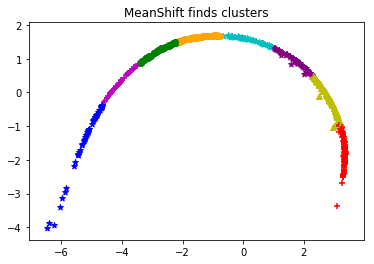

In [151]:
# MDS alt plot
# truncated svd
for i in range(0, mds_data.shape[0]):
    if spectral_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif spectral_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif spectral_mds.labels_[i] == 2:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
    elif spectral_mds.labels_[i] == 3:
        c4 = plt.scatter(mds_data[i,0], mds_data[i,1], c='y', marker='^')
    elif spectral_mds.labels_[i] == 4:
        c5 = plt.scatter(mds_data[i,0], mds_data[i,1], c='c', marker='*')
    elif spectral_mds.labels_[i] == 5:
        c6 = plt.scatter(mds_data[i,0], mds_data[i,1], c='m', marker='+')
    elif spectral_mds.labels_[i] == 6:
        c7 = plt.scatter(mds_data[i,0], mds_data[i,1], c='orange', marker='o')
    elif spectral_mds.labels_[i] == 7:
        c8 = plt.scatter(mds_data[i,0], mds_data[i,1], c='purple', marker='*')

#plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds clusters')
plt.show()

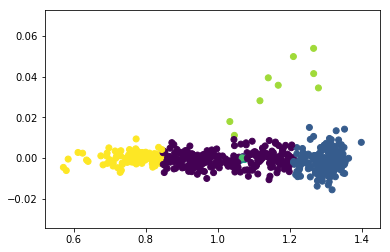

In [152]:
# tSNE
tsvd_spectral = spectral.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral.labels_)

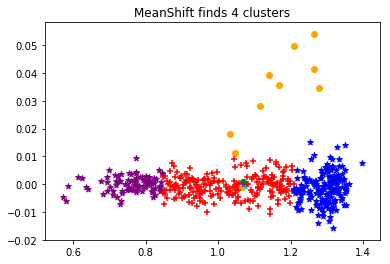

In [153]:
# tSNE alt plot
# truncated svd
for i in range(0, t_svd_data.shape[0]):
    if tsvd_spectral.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_spectral.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_spectral.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_spectral.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')
    elif tsvd_spectral.labels_[i] == 4:
        c5 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='c', marker='*')
    elif tsvd_spectral.labels_[i] == 5:
        c6 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='m', marker='+')
    elif tsvd_spectral.labels_[i] == 6:
        c7 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='orange', marker='o')
    elif tsvd_spectral.labels_[i] == 7:
        c8 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='purple', marker='*')

plt.title('MeanShift finds 4 clusters')
plt.show()

## Affinity Propogation

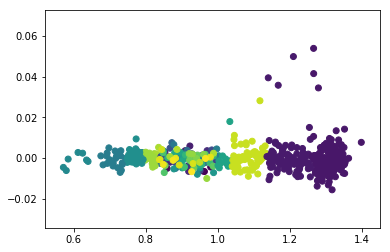

In [154]:
# t SVD
tsvd_affinity = affinity.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_affinity.labels_)

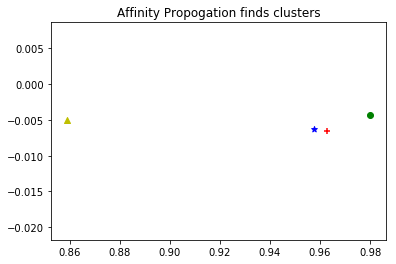

In [155]:
# tSVD
# truncated svd
for i in range(0, t_svd_data.shape[0]):
    if tsvd_affinity.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_affinity.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_affinity.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_affinity.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')

plt.title('Affinity Propogation finds clusters')
plt.show()

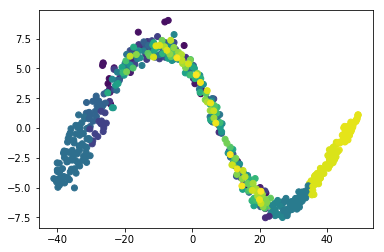

In [156]:
#tSNE
tsne_affinity = affinity.fit(tsne_data)
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_affinity.labels_)

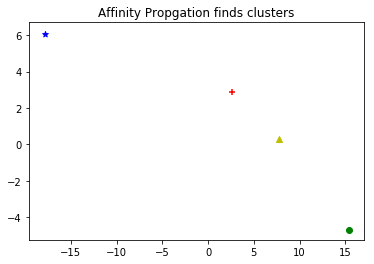

In [157]:
#tSNE
# truncated svd
for i in range(0, tsne_data.shape[0]):
    if tsne_affinity.labels_[i] == 0:
        c1 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='r', marker='+')
    elif tsne_affinity.labels_[i] == 1:
        c2 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='g', marker='o')
    elif tsne_affinity.labels_[i] == 2:
        c3 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='b', marker='*')
    elif tsne_affinity.labels_[i] == 3:
        c4 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='y', marker='^')

plt.title('Affinity Propgation finds clusters')
plt.show()

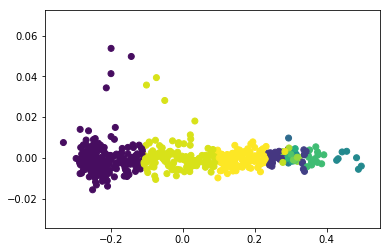

In [160]:
# PCA
affinity_pca = affinity.fit(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:,1], c = affinity_pca.labels_)

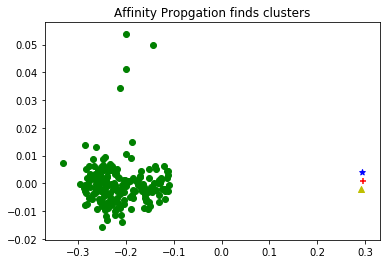

In [161]:
#PCA
# truncated svd
for i in range(0, pca_data.shape[0]):
    if affinity_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif affinity_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif affinity_pca.labels_[i] == 2:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
    elif affinity_pca.labels_[i] == 3:
        c4 = plt.scatter(pca_data[i,0], pca_data[i,1], c='y', marker='^')

plt.title('Affinity Propgation finds clusters')
plt.show()

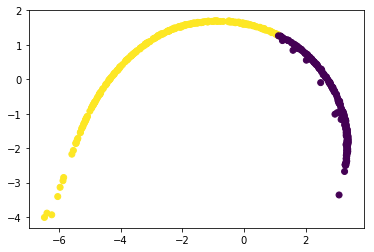

In [162]:
#MDS
affinity_mds = affinity.fit(mds_data)
plt.scatter(mds_data[:, 0], mds_data[:,1], c = tsvd_meanshift.labels_)

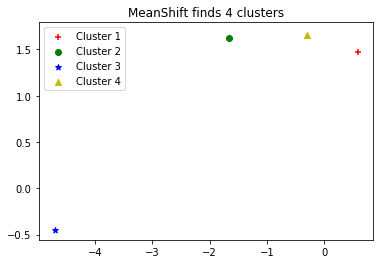

In [163]:
#MDS
# truncated svd
for i in range(0, mds_data.shape[0]):
    if affinity_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif affinity_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif affinity_mds.labels_[i] == 2:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
    elif affinity_mds.labels_[i] == 3:
        c4 = plt.scatter(mds_data[i,0], mds_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()